# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels_20percent.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels_20percent.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(25192, 120)

In [4]:
dataset.kdd_test_2labels.shape

(11850, 120)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    
    y_train = y_output.values
    y_test = y_test.values
    
    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    
    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.98738571771904593

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 120
    classes = 2
    hidden_encoder_dim = 120
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 120
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.x, self.x_hat) #tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            loss = tf.where(tf.is_nan(self.regularized_loss), 1e-2, self.regularized_loss)
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate= self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_nsl_kdd_/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                      net.regularized_loss, 
                                                      ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})

                        train_batch()

                        count = 10
                        if((train_loss > 1e4 or np.isnan(train_loss) ) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, test_loss, accuracy))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_nsl_kdd_/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, time.perf_counter() - start_time))})

            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [30]
    lrs = [1e-2, 1e-3]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.574052 | Test Loss: 2.335153 | Test Accuracy: 0.646667
Step 2 | Training Loss: 0.583884 | Test Loss: 2.068980 | Test Accuracy: 0.675949
Step 3 | Training Loss: 0.433718 | Test Loss: 2.068823 | Test Accuracy: 0.648776
Step 4 | Training Loss: 0.260634 | Test Loss: 2.002675 | Test Accuracy: 0.591392
Step 5 | Training Loss: 0.281813 | Test Loss: 1.958829 | Test Accuracy: 0.589958
Step 6 | Training Loss: 0.700573 | Test Loss: 1.915372 | Test Accuracy: 0.608017
Step 7 | Training Loss: 0.237237 | Test Loss: 302.036987 | Test Accuracy: 0.573671
Step 8 | Training Loss: 0.243260 | Test Loss: 1.898498 | Test Accuracy: 0.566414
Step 9 | Training Loss: 2.113897 | Test Loss: 3.185307 | Test Accuracy: 0.673165
Step 10 | Training Loss: 0.241062 | Test Loss: 20724250434067830407168.000000 | Test Accuracy: 0.599325
Step 11 | High Training Loss: 371534016.000000 ... Restoring Net
INFO:tensorflow:Restoring para

Step 3 | Training Loss: 0.236516 | Test Loss: 2.200771 | Test Accuracy: 0.715865
Step 4 | Training Loss: 0.373883 | Test Loss: 2.193910 | Test Accuracy: 0.712743
Step 5 | Training Loss: 0.493780 | Test Loss: 2.188111 | Test Accuracy: 0.714177
Step 6 | Training Loss: 0.472519 | Test Loss: 2.185574 | Test Accuracy: 0.713840
Step 7 | Training Loss: 0.214298 | Test Loss: 2.182297 | Test Accuracy: 0.711308
Step 8 | Training Loss: 0.210250 | Test Loss: 2.176536 | Test Accuracy: 0.718987
Step 9 | Training Loss: 0.262518 | Test Loss: 2.166793 | Test Accuracy: 0.721603
Step 10 | Training Loss: 0.279417 | Test Loss: 2.160978 | Test Accuracy: 0.737553
Step 11 | Training Loss: 0.869849 | Test Loss: 2.153072 | Test Accuracy: 0.709958
Step 12 | Training Loss: 0.409115 | Test Loss: 2.145694 | Test Accuracy: 0.709451
Step 13 | Training Loss: 0.408111 | Test Loss: 2.138989 | Test Accuracy: 0.723122
Step 14 | Training Loss: 0.086861 | Test Loss: 2.131751 | Test Accuracy: 0.703882
Step 15 | Training Loss

Step 8 | Training Loss: 0.422368 | Test Loss: 2.152647 | Test Accuracy: 0.718481
Step 9 | Training Loss: 0.377574 | Test Loss: 2.271391 | Test Accuracy: 0.656287
Step 10 | Training Loss: 0.241165 | Test Loss: 2.206207 | Test Accuracy: 0.697384
Step 11 | Training Loss: 0.618234 | Test Loss: 2.210175 | Test Accuracy: 0.763882
Step 12 | Training Loss: 0.242148 | Test Loss: 2.195804 | Test Accuracy: 0.722447
Step 13 | Training Loss: 0.385182 | Test Loss: 2.197403 | Test Accuracy: 0.715274
Step 14 | Training Loss: 0.221208 | Test Loss: 2.192638 | Test Accuracy: 0.756034
Step 15 | Training Loss: 0.305081 | Test Loss: 2.195614 | Test Accuracy: 0.763460
Step 16 | Training Loss: 0.607320 | Test Loss: 2.208337 | Test Accuracy: 0.790717
Step 17 | Training Loss: 0.421015 | Test Loss: 2.229458 | Test Accuracy: 0.722447
Step 18 | Training Loss: 0.416933 | Test Loss: 2.350117 | Test Accuracy: 0.752658
Step 19 | Training Loss: 0.485245 | Test Loss: 2.437562 | Test Accuracy: 0.739916
Step 20 | High Tra

Step 16 | Training Loss: 0.993264 | Test Loss: 2.488796 | Test Accuracy: 0.686920
Step 17 | Training Loss: 0.503497 | Test Loss: 2.485852 | Test Accuracy: 0.683797
Step 18 | Training Loss: 0.649203 | Test Loss: 2.490972 | Test Accuracy: 0.685992
Step 19 | Training Loss: 0.602391 | Test Loss: 2.489502 | Test Accuracy: 0.676287
Step 20 | Training Loss: 0.448927 | Test Loss: 2.490046 | Test Accuracy: 0.672068
Step 21 | Training Loss: 0.532136 | Test Loss: 2.489329 | Test Accuracy: 0.669620
Step 22 | Training Loss: 0.732999 | Test Loss: 2.490494 | Test Accuracy: 0.670717
Step 23 | Training Loss: 0.976520 | Test Loss: 2.489082 | Test Accuracy: 0.670127
Step 24 | Training Loss: 0.594091 | Test Loss: 2.489421 | Test Accuracy: 0.664219
Step 25 | Training Loss: 0.643075 | Test Loss: 2.493191 | Test Accuracy: 0.653080
Step 26 | Training Loss: 0.729153 | Test Loss: 2.489306 | Test Accuracy: 0.653924
Step 27 | Training Loss: 0.566597 | Test Loss: 2.486284 | Test Accuracy: 0.642278
Step 28 | Traini

Step 17 | Training Loss: 0.745766 | Test Loss:    nan | Test Accuracy: 0.627173
Step 18 | Training Loss: 0.788417 | Test Loss: 2.677246 | Test Accuracy: 0.755443
Step 19 | Training Loss: 0.980834 | Test Loss: 2.675009 | Test Accuracy: 0.712827
Step 20 | Training Loss: 0.859077 | Test Loss: 2.670275 | Test Accuracy: 0.697046
Step 21 | Training Loss: 1.193166 | Test Loss: 2.668959 | Test Accuracy: 0.690717
Step 22 | Training Loss: 1.075113 | Test Loss: 2.692595 | Test Accuracy: 0.677131
Step 23 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd/hidden layers_30_features count_4/model-9
Step 23 | Training Loss: 0.739810 | Test Loss: 2.712285 | Test Accuracy: 0.765148
Step 24 | Training Loss: 0.696324 | Test Loss:    nan | Test Accuracy: 0.785654
Step 25 | Training Loss: 0.832668 | Test Loss: 2.667233 | Test Accuracy: 0.715359
Step 26 | Training Loss: 0.627558 | Test Loss: 2.660372 | Test Accuracy: 0.738819
Step 27 | Training L

Step 19 | Training Loss: 0.895462 | Test Loss: 2.700088 | Test Accuracy: 0.181603
Step 20 | Training Loss: 0.753852 | Test Loss: 2.700157 | Test Accuracy: 0.181603
Step 21 | Training Loss: 0.736832 | Test Loss: 2.700557 | Test Accuracy: 0.181603
Step 22 | Training Loss: 0.846608 | Test Loss: 2.700587 | Test Accuracy: 0.181603
Step 23 | Training Loss: 0.957916 | Test Loss: 2.700220 | Test Accuracy: 0.181603
Step 24 | Training Loss: 0.954226 | Test Loss: 2.700250 | Test Accuracy: 0.181603
Step 25 | Training Loss: 0.854602 | Test Loss: 2.700665 | Test Accuracy: 0.181603
Step 26 | Training Loss: 0.824178 | Test Loss: 2.699965 | Test Accuracy: 0.181603
Step 27 | Training Loss: 0.691408 | Test Loss: 2.700863 | Test Accuracy: 0.181603
Step 28 | Training Loss: 0.749024 | Test Loss: 2.700379 | Test Accuracy: 0.181603
Step 29 | Training Loss: 0.926796 | Test Loss: 2.700213 | Test Accuracy: 0.181603
Step 30 | Training Loss: 0.713358 | Test Loss: 2.700558 | Test Accuracy: 0.181603
Current Layer At

Step 23 | Training Loss: 0.615846 | Test Loss: 2.577005 | Test Accuracy: 0.586329
Step 24 | Training Loss: 1.147546 | Test Loss: 2.598381 | Test Accuracy: 0.510295
Step 25 | Training Loss: 0.650040 | Test Loss: 2.568516 | Test Accuracy: 0.494346
Step 26 | Training Loss: 2.746644 | Test Loss: 2.668478 | Test Accuracy: 0.260928
Step 27 | Training Loss: 1.761760 | Test Loss: 2.660877 | Test Accuracy: 0.268608
Step 28 | Training Loss: 0.846083 | Test Loss: 2.666843 | Test Accuracy: 0.269283
Step 29 | Training Loss: 1.219241 | Test Loss: 2.672664 | Test Accuracy: 0.272236
Step 30 | Training Loss: 1.046392 | Test Loss: 2.661919 | Test Accuracy: 0.267173
Step 1 | Training Loss: 0.963936 | Test Loss: 2.666081 | Test Accuracy: 0.267173
Step 2 | Training Loss: 0.590166 | Test Loss: 2.662318 | Test Accuracy: 0.267342
Step 3 | Training Loss: 0.697632 | Test Loss: 2.665037 | Test Accuracy: 0.267426
Step 4 | Training Loss: 0.745063 | Test Loss: 2.664091 | Test Accuracy: 0.267342
Step 5 | Training Lo

Step 1 | Training Loss: 0.670230 | Test Loss: 2.548092 | Test Accuracy: 0.564219
Step 2 | Training Loss: 0.835165 | Test Loss: 2.487172 | Test Accuracy: 0.618565
Step 3 | Training Loss: 0.480864 | Test Loss: 2.477980 | Test Accuracy: 0.646667
Step 4 | High Training Loss: 65474564.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd/hidden layers_30_features count_6/model-3
Step 4 | Training Loss: 1.094981 | Test Loss: 2.447288 | Test Accuracy: 0.600000
Step 5 | Training Loss: 1.249696 | Test Loss: 2.702206 | Test Accuracy: 0.181603
Step 6 | Training Loss: 0.926438 | Test Loss: 2.697980 | Test Accuracy: 0.181603
Step 7 | Training Loss: 0.835806 | Test Loss: 2.702135 | Test Accuracy: 0.181603
Step 8 | Training Loss: 0.711051 | Test Loss: 2.701805 | Test Accuracy: 0.181603
Step 9 | Training Loss: 2.035632 | Test Loss: 2.701527 | Test Accuracy: 0.181603
Step 10 | Training Loss: 0.790461 | Test Loss: 2.700119 | Test Accuracy: 0.181603
Step 11 | Trai

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)
    

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [14]:
df_results.sort_values(by = 'test_score_20', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score_20,time_taken
5,60,8,4,0.895238,0.827257,39.408376
1,60,8,2,0.941270,0.805401,13.713601
4,60,4,4,0.819048,0.803629,51.249798
6,60,16,4,0.907143,0.796709,68.068779
3,60,32,2,0.955159,0.790717,19.271533
2,60,16,2,0.957937,0.760928,23.470151
8,60,4,6,0.907540,0.707426,9.525825
0,60,4,2,0.929762,0.694515,19.162631
7,60,32,4,0.957143,0.648945,7.331090
11,60,32,6,0.919048,0.646667,8.071786


In [15]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions-.pkl")
df_results.to_pickle("dataset/tf_vae_only_nsl_kdd_scores-.pkl")

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.7807  0.2193]
 [ 0.1624  0.8376]]


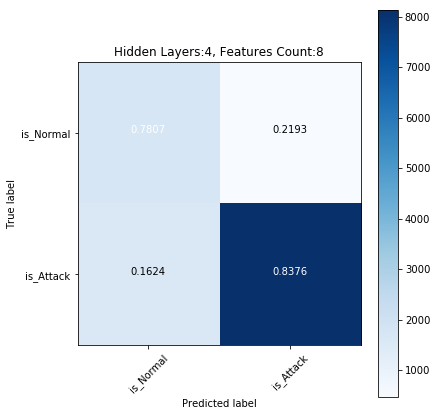

In [17]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)